In [1]:
#bunch of modules to import 
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras import layers
import os
import cv2

Using TensorFlow backend.


In [2]:
DATADIR = "C:/Users/Alfred Lam/Pictures/spriteData/graySprites"
CATEGORIES=["z1","z2","z3","z4","z5","z6","z7","z8","z9","z10","z11","z12","z13","z14","z15","z16","z17","z18","z19"]
IMG_SIZE = 32

In [3]:
training_data = []
testing_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                if class_num >= 17:
                    testing_data.append([new_array, class_num])
                else:
                    training_data.append([new_array, class_num])
            except Exception as e:
                print("fail")
                pass
            #plt.imshow(img_array, cmap="gray")
            #plt.show()
            #print(img_array.shape)

create_training_data()
print(len(training_data))
print(len(testing_data))

1590
192


In [5]:
train_data = []
train_labels = []
test_data = []
test_labels = []

for features, label in training_data:
    train_data.append(features)
    train_labels.append(label)
    
for features, label in testing_data:
    test_data.append(features)
    test_labels.append(label)

train_data = np.array(train_data).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_data = np.array(test_data).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
train_data.shape, test_data.shape

((1590, 32, 32, 1), (192, 32, 32, 1))

In [6]:
img_shape = (IMG_SIZE, IMG_SIZE, 1)    # for MNIST
batch_size = 128
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

In [7]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

In [8]:
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [9]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [10]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [11]:
train_data.dtype, test_data.dtype

(dtype('uint8'), dtype('uint8'))

In [12]:
np.max(train_data), np.max(test_data)

(255, 255)

In [13]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [14]:
np.max(train_data), np.max(test_data)



(1.0, 1.0)

In [18]:
vae.fit(x=train_data, y=None,
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(test_data, None))

Train on 1590 samples, validate on 192 samples
Epoch 1/50
1590/1590 [==============================] - 7s 4ms/step - loss: 0.4654 - val_loss: 0.6395
Epoch 2/50
1590/1590 [==============================] - 7s 4ms/step - loss: 0.4664 - val_loss: 0.6279
Epoch 3/50
1590/1590 [==============================] - 7s 4ms/step - loss: 0.4607 - val_loss: 0.6213
Epoch 4/50
1590/1590 [==============================] - 7s 4ms/step - loss: 0.4635 - val_loss: 0.6353
Epoch 5/50
1590/1590 [==============================] - 7s 4ms/step - loss: 0.4616 - val_loss: 0.6126
Epoch 6/50
1590/1590 [==============================] - 7s 4ms/step - loss: 0.4595 - val_loss: 0.6278
Epoch 7/50
1590/1590 [==============================] - 7s 4ms/step - loss: 0.4583 - val_loss: 0.6037
Epoch 8/50
1590/1590 [==============================] - 7s 4ms/step - loss: 0.4603 - val_loss: 0.6271
Epoch 9/50
1590/1590 [==============================] - 7s 4ms/step - loss: 0.4575 - val_loss: 0.6192
Epoch 10/50
1590/1590 [============

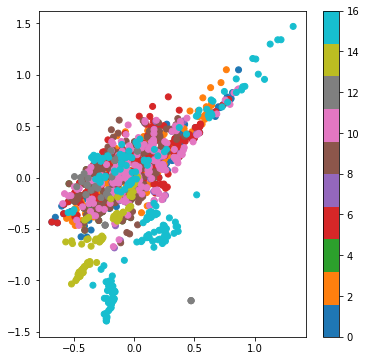

In [19]:
# build a model to project inputs on the latent space
encoder = Model(input_img, z_mu)

# display a 2D plot of the digit classes in the latent space
def plot_latentSpace(encoder, test_data, test_labels, batch_size):
    x_test_encoded = encoder.predict(test_data, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=test_labels, cmap='tab10')
    plt.colorbar()
    plt.show()
    
plot_latentSpace(encoder, train_data, train_labels, batch_size)

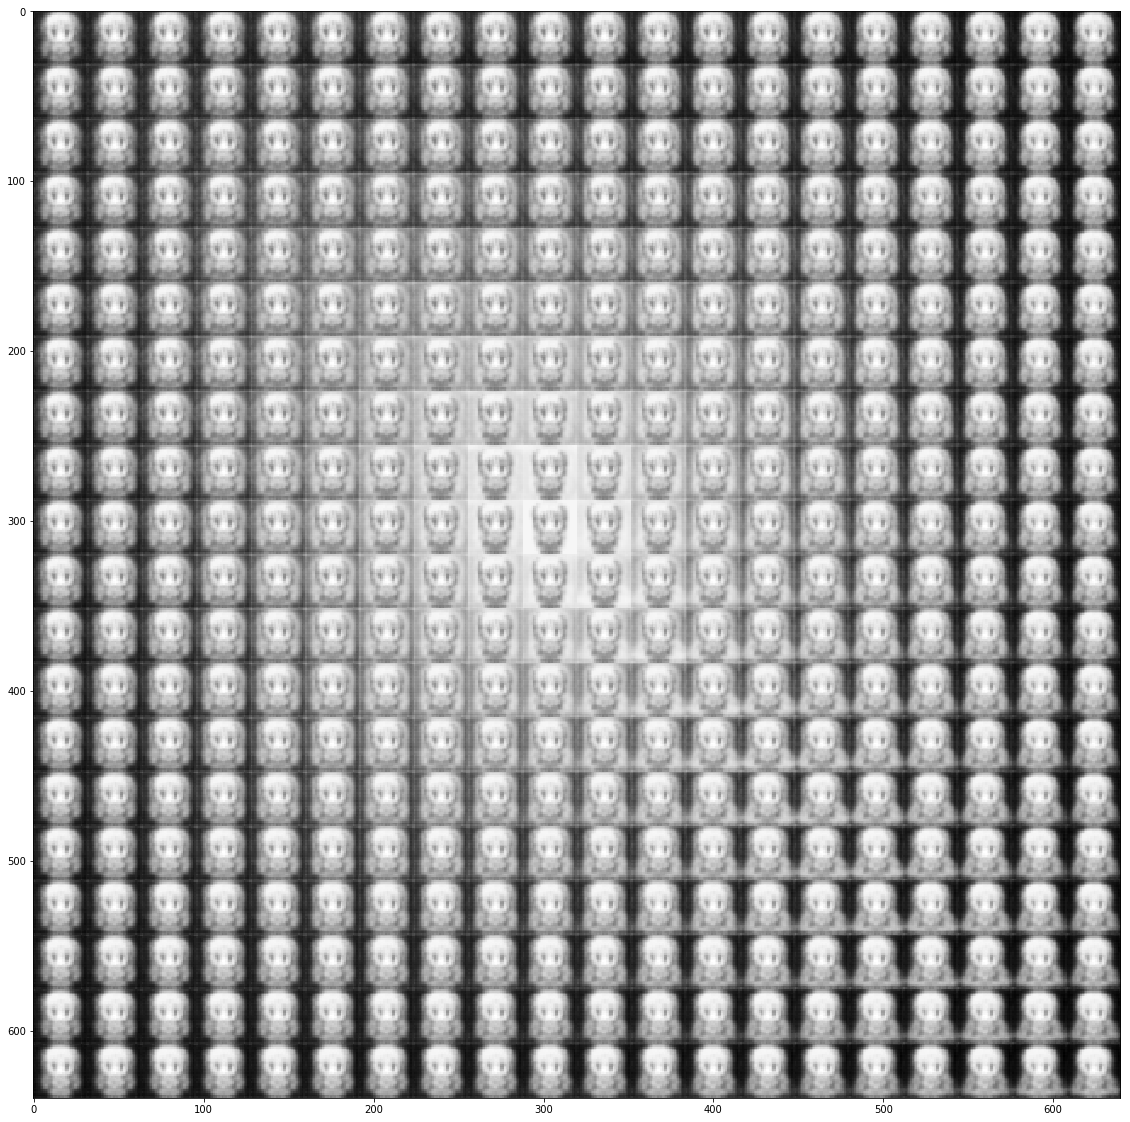

In [20]:
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.15, 0.85, n))
grid_y = norm.ppf(np.linspace(0.15, 0.85, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, latent_dim)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape((digit_size, digit_size))
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='gray')
plt.show()  